In [243]:
import pandas as pd
import numpy as np 

import yfinance as yf
import mplfinance as mpf

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

### Initial Questions:

- Does BTC's price have a correlation with the DJI?
- Does BTC's price have a relationship with Gold?
- How does the volatility of BTC compare with that of the DJI and Gold?
- How does the behavior of BTC, the DJI, and Gold change during periods of market stress or economic uncertainty?

## Acquire 

In [103]:
# specify the stock symbol
btc = "BTC-USD"

# retrieve the historical data
btc_df = yf.download(btc, start="2010-01-01", end="2023-2-13")
btc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,22939.398438,25371367758
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,21819.039062,32572572185
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,21651.183594,27078406594


In [102]:
# specify the stock symbol
gold = "GC=F"

# retrieve the historical data
gold_df = yf.download(gold, start="2010-01-01", end="2023-2-13")
gold_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,1138.199951,54
...,...,...,...,...,...,...
2023-02-06,1865.599976,1880.000000,1863.400024,1866.199951,1866.199951,424
2023-02-07,1870.000000,1875.699951,1868.000000,1871.699951,1871.699951,297
2023-02-08,1872.099976,1880.400024,1872.099976,1877.400024,1877.400024,230


In [105]:
# specify the stock symbol
dji = "^DJI"

# retrieve the historical data
dji_df = yf.download(dji, start="2010-01-01", end="2023-2-13")
dji_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,10618.190430,172710000
...,...,...,...,...,...,...
2023-02-06,33874.441406,33962.839844,33683.578125,33891.019531,33891.019531,296400000
2023-02-07,33769.781250,34240.000000,33634.101562,34156.691406,34156.691406,361620000
2023-02-08,34132.898438,34161.648438,33899.789062,33949.011719,33949.011719,324090000


## Prepare

In [106]:
df_btc_gold = pd.merge(btc_df['Adj Close'], gold_df['Adj Close'], on="Date")

In [107]:
df_btc_gold

,Adj Close_x,Adj Close_y
Date,,
2014-09-17,457.334015,1234.400024
2014-09-18,424.440002,1225.699951
2014-09-19,394.795990,1215.300049
2014-09-22,402.152008,1216.800049
2014-09-23,435.790985,1221.000000
...,...,...
2023-02-06,22760.109375,1866.199951
2023-02-07,23264.291016,1871.699951
2023-02-08,22939.398438,1877.400024


In [108]:
df = pd.merge(df_btc_gold, dji_df['Adj Close'], on="Date")

In [109]:
df.rename(columns= {'Adj Close_x': 'btc_price',
                    'Adj Close_y': 'gold_price',
                    'Adj Close': 'dji_price'}, inplace = True )

In [113]:
df.index.name = 'date'

In [129]:
max_date = pd.Timestamp('2022-12-31')

df = df[df.index <= max_date]

In [130]:
df

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.334015,1234.400024,17156.849609
2014-09-18,424.440002,1225.699951,17265.990234
2014-09-19,394.795990,1215.300049,17279.740234
2014-09-22,402.152008,1216.800049,17172.679688
2014-09-23,435.790985,1221.000000,17055.869141
...,...,...,...
2022-12-23,16796.953125,1795.900024,33203.929688
2022-12-27,16717.173828,1814.800049,33241.558594
2022-12-28,16552.572266,1807.900024,32875.710938


In [132]:
df.isna().sum()

btc_price     0
gold_price    0
dji_price     0
dtype: int64

In [135]:
df.index.dtype

dtype('<M8[ns]')

In [137]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
btc_price,2085.0,12886.055939,16212.890916,178.102997,673.106018,7116.804199,16830.341797,67566.828125
gold_price,2085.0,1453.485275,272.686302,1050.800049,1229.500000,1319.300049,1750.000000,2051.500000
dji_price,2085.0,25038.530906,6011.734093,15660.179688,18516.550781,25090.480469,29591.269531,36799.648438


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2014-09-17 to 2022-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_price   2085 non-null   float64
 1   gold_price  2085 non-null   float64
 2   dji_price   2085 non-null   float64
dtypes: float64(3)
memory usage: 65.2 KB


In [148]:
df = df.round(2)
df.head(3)

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74


In [149]:
df_year = df.resample('Y').sum()
df_month = df.resample('M').sum()
df_quarter = df.resample('3M').sum()

In [150]:
df_year

,btc_price,gold_price,dji_price
date,,,
2014-12-31,27073.94,89073.6,1281381.14
2015-12-31,68653.13,292028.6,4431946.25
2016-12-31,141825.27,312426.5,4480454.35
2017-12-31,1002684.08,315682.0,5459301.14
2018-12-31,1886178.69,316899.9,6262101.96
2019-12-31,1866064.46,350966.0,6647645.04
2020-12-31,2820386.82,448610.5,6803340.42
2021-12-31,11973968.36,453012.6,8581933.02
2022-12-31,7080591.92,451817.1,8257233.64


## Split Data

In [199]:
df.shape

(2085, 3)

In [200]:
train_size = int(round(df.shape[0] * 0.5))
validate_size = int(round(df.shape[0] * 0.3))
test_size = int(round(df.shape[0] * 0.2))
train_size, validate_size, test_size

(1042, 626, 417)

In [201]:
len(df) == train_size + validate_size + test_size


True

In [202]:
validate_end_index = train_size + validate_size
validate_end_index

1668

In [205]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [206]:
train.shape[0], validate.shape[0], test.shape[0]

(1042, 626, 417)

In [207]:
len(train) + len(validate) + len(test) == len(df)

True

## Explore

<AxesSubplot:xlabel='date'>

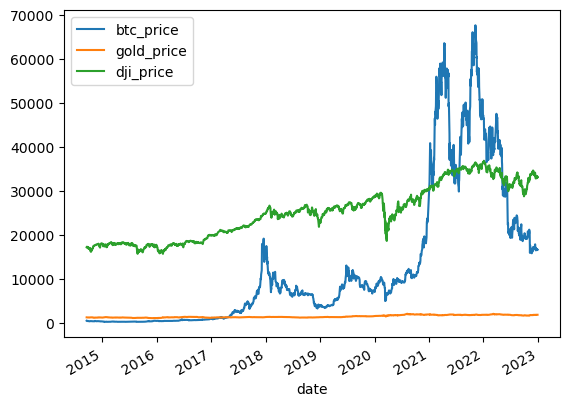

In [153]:
df.plot()

<AxesSubplot:xlabel='date'>

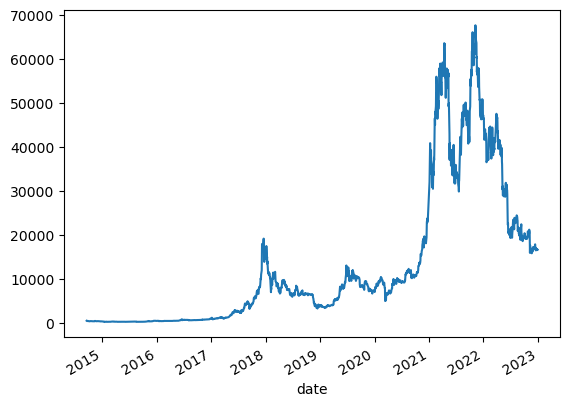

In [154]:
df['btc_price'].plot()

<AxesSubplot:xlabel='date'>

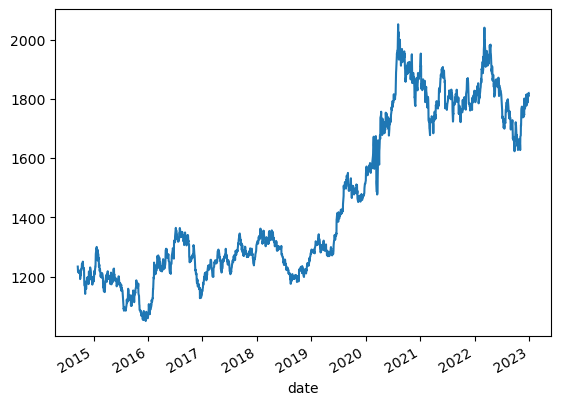

In [152]:
df['gold_price'].plot()

<AxesSubplot:xlabel='date'>

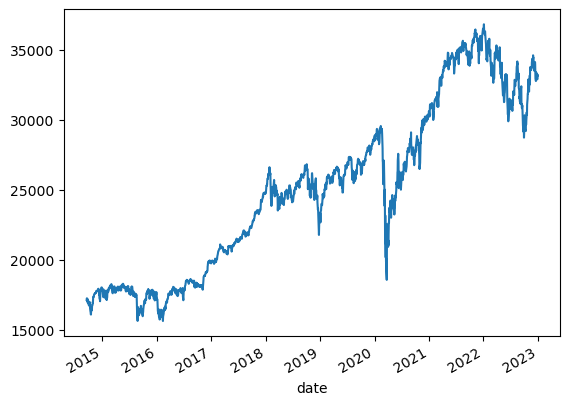

In [156]:
df['dji_price'].plot()

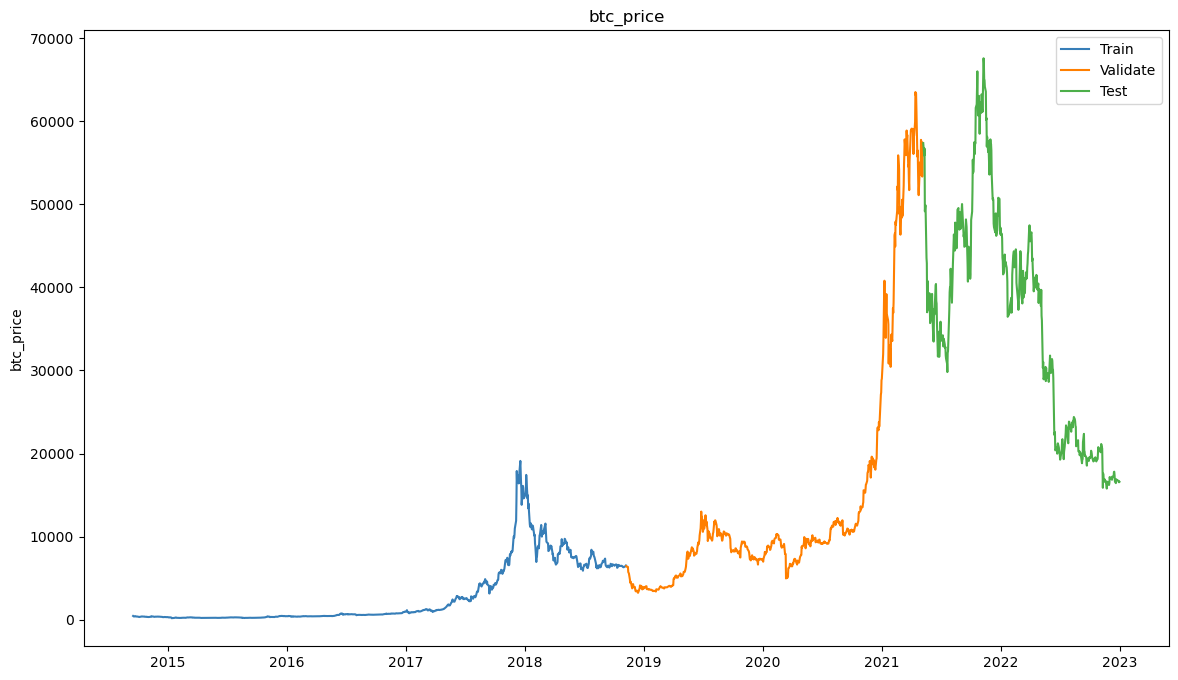

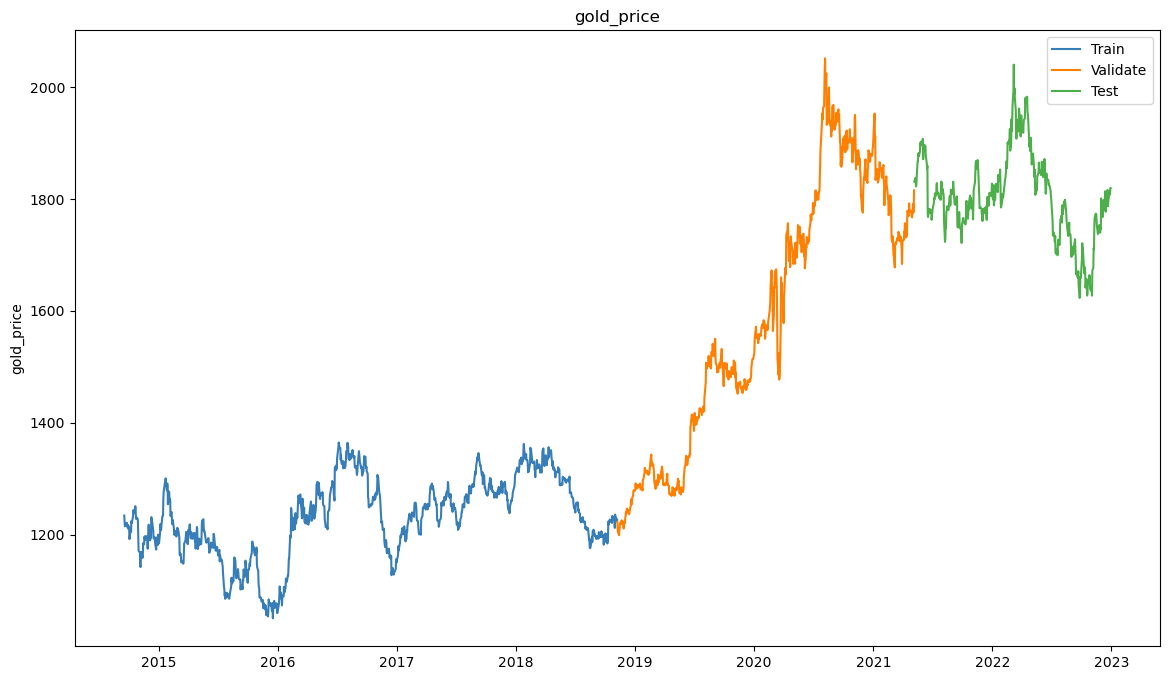

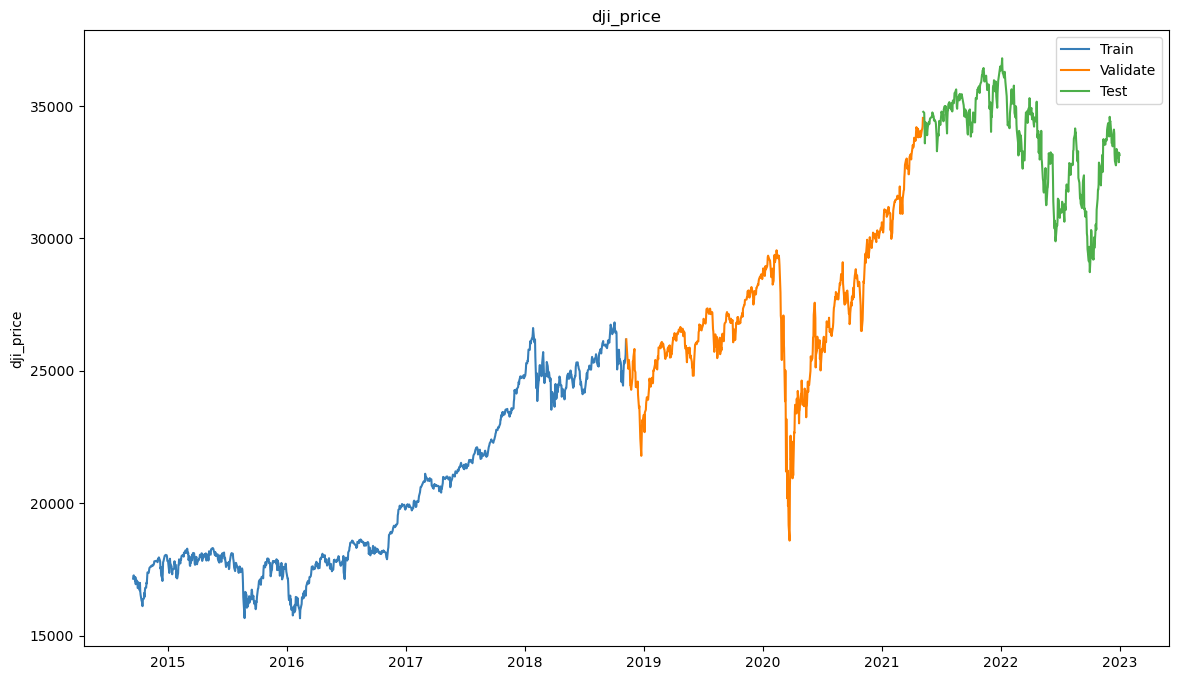

In [208]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

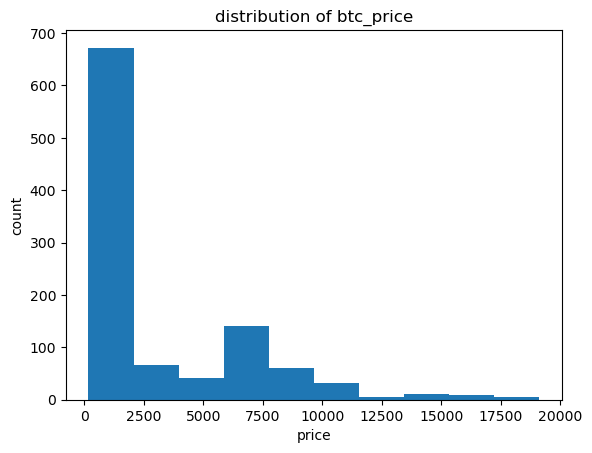

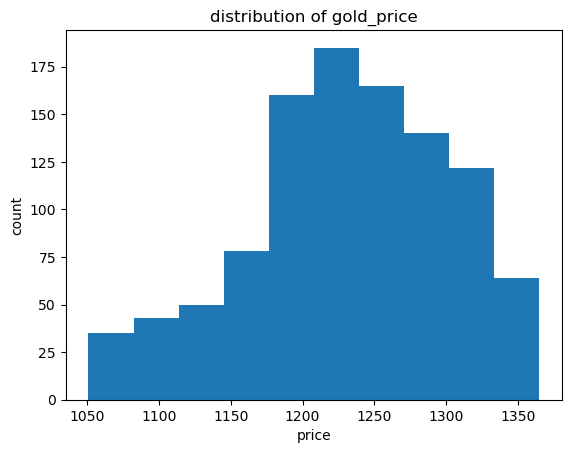

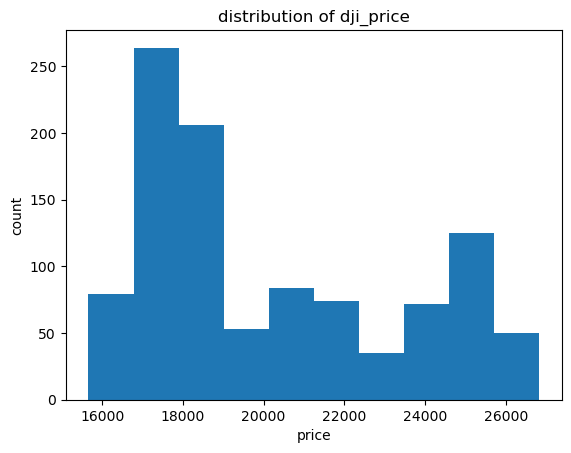

In [225]:
for i in train.columns:
    plt.hist(train[i])
    plt.xlabel('price')
    plt.ylabel('count')
    plt.title(f'distribution of {i}')
    plt.show()

In [287]:
month_mean = train['btc_price'].resample('M').mean()
month_mean = pd.DataFrame(month_mean)

month_mean['shifted'] = month_mean['btc_price'].shift(-1)
month_mean.head()

,btc_price,shifted
date,,
2014-09-30,411.611000,365.888696
2014-10-31,365.888696,369.204737
2014-11-30,369.204737,342.159091
2014-12-31,342.159091,248.440000
2015-01-31,248.440000,232.495263


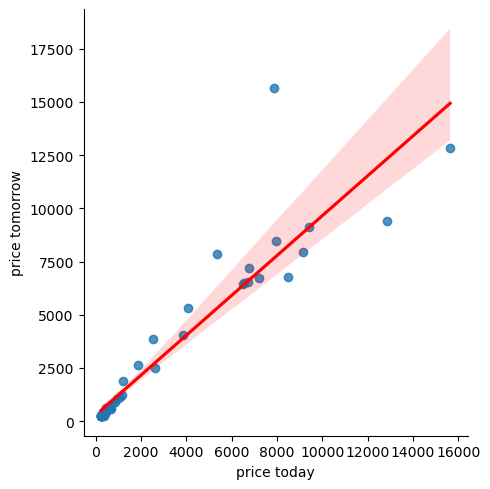

In [291]:
sns.lmplot(data = month_mean, x = 'btc_price', y = 'shifted', line_kws= {'color': 'red'})
plt.xlabel('price today')
plt.ylabel('price tomorrow')
plt.show()

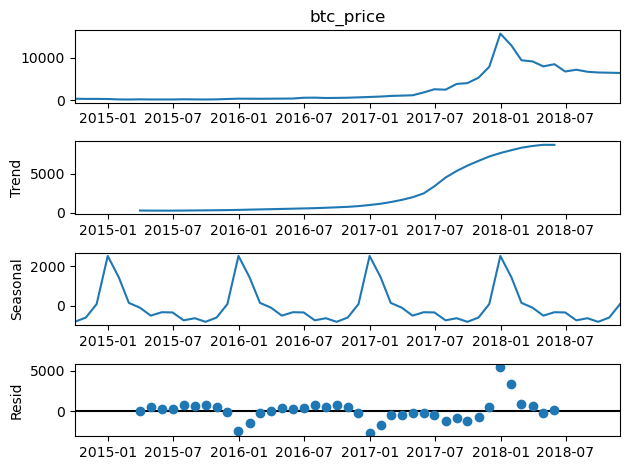

In [240]:
result = sm.tsa.seasonal_decompose(train['btc_price'].resample('M').mean())

result.plot()
plt.show()

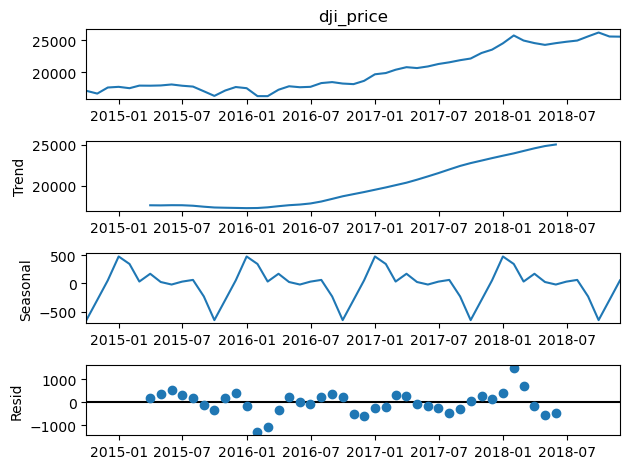

In [235]:
result = sm.tsa.seasonal_decompose(train['dji_price'].resample('M').mean())

result.plot()
plt.show()

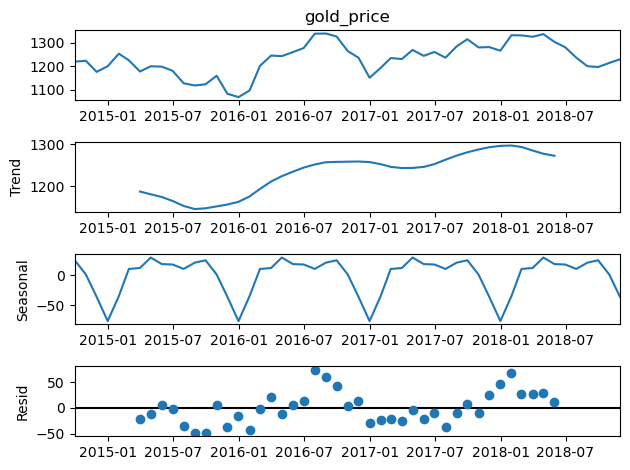

In [236]:
result = sm.tsa.seasonal_decompose(train['gold_price'].resample('M').mean())

result.plot()
plt.show()

### **1. Does BTC's price have a correlation with the DJI?**

<AxesSubplot:xlabel='date'>

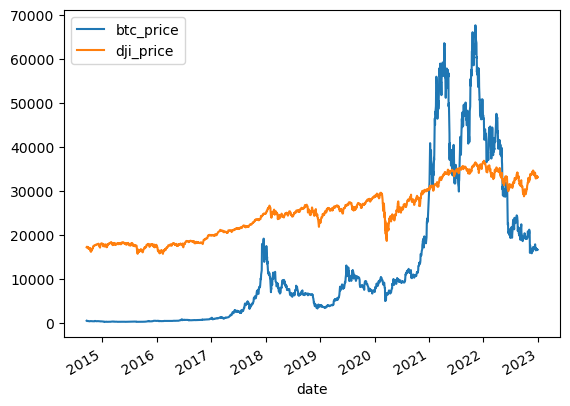

In [157]:
df[['btc_price','dji_price']].plot()

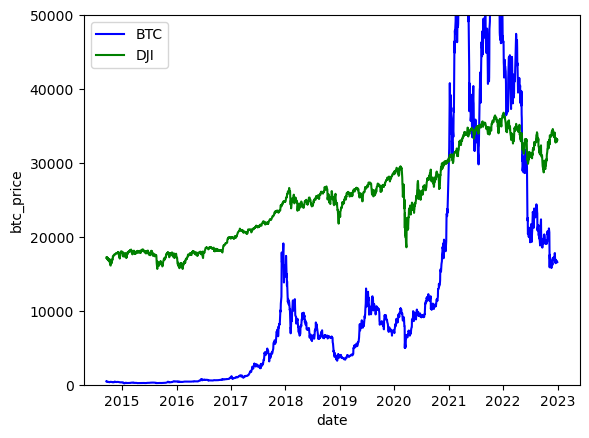

In [214]:
sns.lineplot(data=df, x='date', y='btc_price', color='blue', label='BTC')
sns.lineplot(data=df, x='date', y='dji_price', color='green', label='DJI')
#plt.xlim(2019)
plt.ylim(0,50000)
plt.legend()
plt.show()

$H_0$: There is no correlation between the BTC and DJI price

$H_a$: There is a correlation between the BTC and DJI price

$\alpha$ = 0.05

In [213]:
α = 0.05
# Calculate the Pearson's correlation coefficient
r, p = pearsonr(df['btc_price'], df['dji_price'])

print("Pearson's correlation coefficient:", r)
print("p-value:", p)

if p < α:
    print('We reject the null hypothesis') 
else:
    print('We fail to reject the null hypothesis')

Pearson's correlation coefficient: 0.8560544423948482
p-value: 0.0
We reject the null hypothesis


**Takeaways**

We reject the null hypothesis meaning there is a correlation between the DJI and BTC price. There is a strong correlation to be specific.

### **2. Does BTC's price have a relationship with Gold?** 

<AxesSubplot:xlabel='date'>

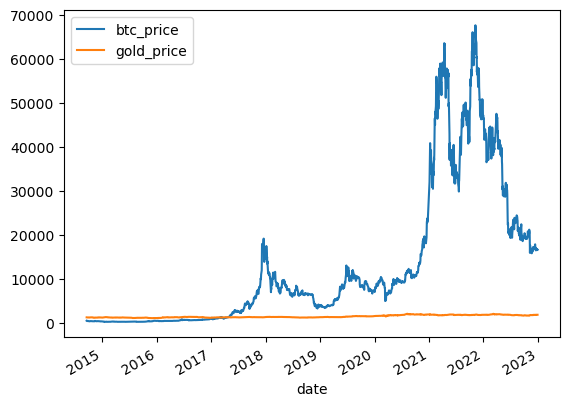

In [216]:
df[['btc_price','gold_price']].plot()

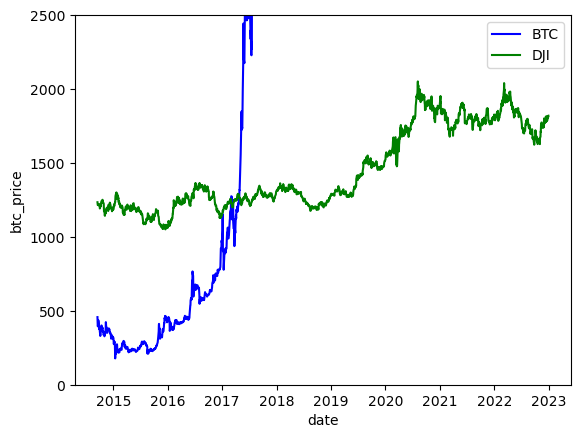

In [219]:
sns.lineplot(data=df, x='date', y='btc_price', color='blue', label='BTC')
sns.lineplot(data=df, x='date', y='gold_price', color='green', label='DJI')
#plt.xlim(2019)
plt.ylim(0,2500)
plt.legend()
plt.show()

$H_0$: There is no correlation between the BTC and Gold price

$H_a$: There is a correlation between the BTC and Gold price

$\alpha$ = 0.05

In [293]:
α = 0.05
# Calculate the Pearson's correlation coefficient
r, p = pearsonr(df['btc_price'], df['gold_price'])

print("Pearson's correlation coefficient:", r)
print("p-value:", p)

if p < α:
    print('We reject the null hypothesis') 
else:
    print('We fail to reject the null hypothesis')

Pearson's correlation coefficient: 0.7642495379265786
p-value: 0.0
We reject the null hypothesis


**Takeaways** 

We reject the null hypothesis meaning there is a correlation between BTC and Gold have a positive correlation. With a 76% poistive correlation making it somewhat strong. 

### **3. How does the volatility of BTC compare with that of the DJI and Gold?**

In [250]:
# Calculate daily returns for each
btc_returns = btc_df['Close'].pct_change()
dji_returns = dji_df['Close'].pct_change()
gold_returns = gold_df['Close'].pct_change()

In [252]:
# Calculate the standard deviation of daily returns
btc_volatility = btc_returns.std()
dji_volatility = dji_returns.std()
gold_volatility = gold_returns.std()

In [253]:
# Compare the volatilities
print("BTC Volatility:", btc_volatility)
print("DJI Volatility:", dji_volatility)
print("Gold Volatility:", gold_volatility)

BTC Volatility: 0.03816496621162785
DJI Volatility: 0.010854783277123137
Gold Volatility: 0.010191738788816374


Text(0.5, 1.0, 'Volatility')

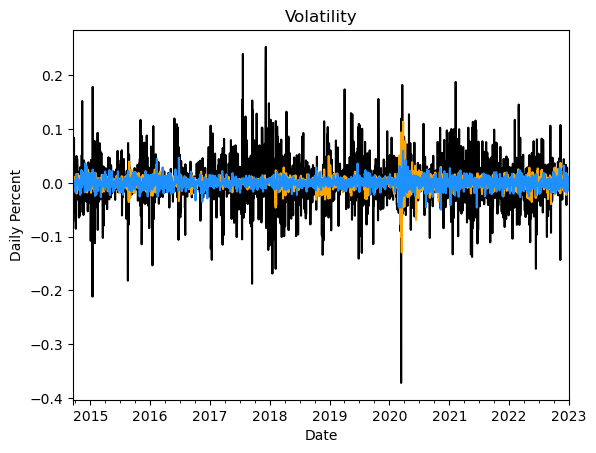

In [296]:
btc_returns.plot(c = 'black')
dji_returns.plot(c = 'orange')
gold_returns.plot(c = 'dodgerblue')
plt.xlim('2014-09-17', '2023-01-01')
plt.ylabel('Daily Percent')
plt.title('Volatility')

**Takeaways**

We see from the chart that BTC is very volatile compared to the DJI and Gold. 

## Modeling

In [297]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [298]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [299]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [302]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [306]:
def make_baseline_predictions(btc_predictions=None):
    yhat_df = pd.DataFrame({'btc_price': btc_predictions},
                          index=validate.index)
    return yhat_df

### Baseline model

In [303]:
period = 50
train['btc_price'].rolling(period).mean()

date
2014-09-17          NaN
2014-09-18          NaN
2014-09-19          NaN
2014-09-22          NaN
2014-09-23          NaN
                ...    
2018-11-01    6567.1114
2018-11-02    6564.1826
2018-11-05    6558.1766
2018-11-06    6549.7040
2018-11-07    6538.3812
Name: btc_price, Length: 1042, dtype: float64

In [336]:
rolling_btc = round(train['btc_price'].rolling(period).mean()[-1], 2)

print(rolling_btc)

6538.38


In [337]:
yhat_df = make_baseline_predictions(rolling_btc)
yhat_df

,btc_price
date,
2018-11-08,6538.38
2018-11-09,6538.38
2018-11-12,6538.38
2018-11-13,6538.38
2018-11-14,6538.38
...,...
2021-04-30,6538.38
2021-05-03,6538.38
2021-05-04,6538.38


btc_price -- RMSE: 16744


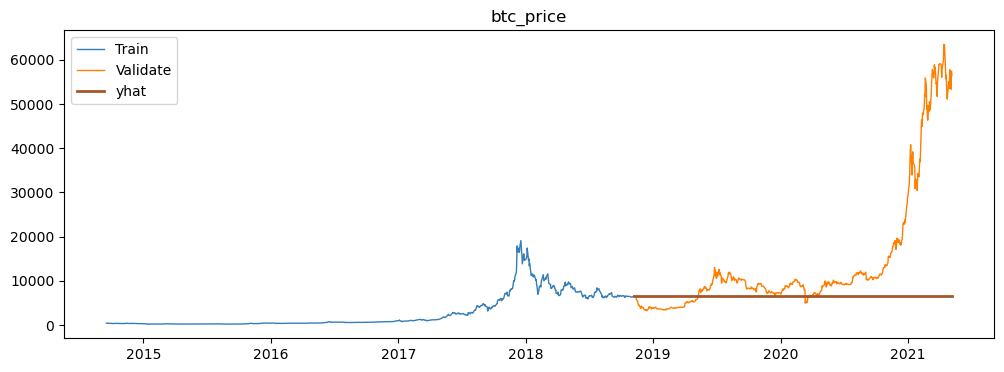

In [338]:
plot_and_eval('btc_price')

In [322]:
train['btc_price_rolling_avg'] = train['btc_price'].rolling(window=50).mean()


<AxesSubplot:xlabel='date'>

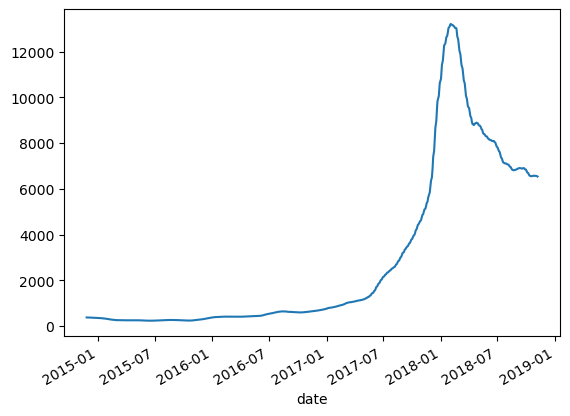

In [325]:
train['btc_price_rolling_avg'].plot()

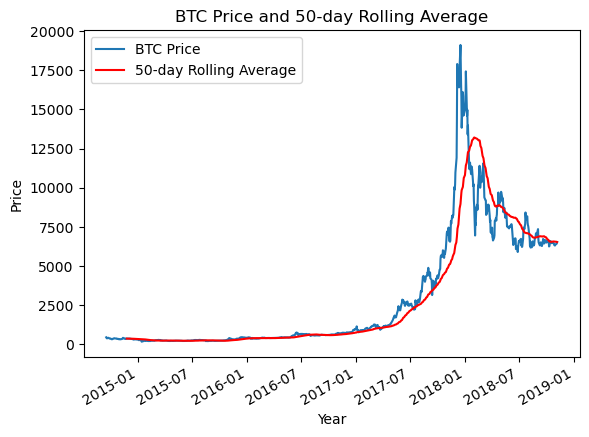

In [328]:
ax = train['btc_price'].plot(label='BTC Price')
train['btc_price_rolling_avg'].plot(ax=ax, label='50-day Rolling Average', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('BTC Price and 50-day Rolling Average')
plt.show()


In [335]:
train

,btc_price,gold_price,dji_price,btc_price_rolling_avg
date,,,,
2014-09-17,457.33,1234.4,17156.85,NaN
2014-09-18,424.44,1225.7,17265.99,NaN
2014-09-19,394.80,1215.3,17279.74,NaN
2014-09-22,402.15,1216.8,17172.68,NaN
2014-09-23,435.79,1221.0,17055.87,NaN
...,...,...,...,...
2018-11-01,6377.78,1236.0,25380.74,6567.1114
2018-11-02,6388.44,1230.9,25270.83,6564.1826
2018-11-05,6419.66,1229.8,25461.70,6558.1766
